In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
import time
import datarobot as dr
import os
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Dict of source data files and relevant text columns
sources = {
    '10kDiabetes': {
        'target': 'readmitted',
        'text_columns': ['diag_1_desc', 'diag_2_desc', 'diag_3_desc'],
        'kmeans_columns' : ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']
    },
    '10K_Lending_Club_Loans': {
        'target': 'is_bad',
        'text_columns': ['emp_title', 'desc', 'purpose', 'title'],
        'kmeans_columns' : ['loan_amnt', 'funded_amnt', 'annual_inc', 'dti', 'open_acc', 'revol_bal']
    }
}

# Designate the source you want to use here:
source_used = '10kDiabetes'

# Read the data file
file_path = 'data/'
file_name = source_used
file_extn = '.csv'
df = pd.read_csv(file_path + file_name + file_extn, encoding = "ISO-8859-1")

# Source target
target = sources.get(source_used).get('target')

# Source text columns
text_columns = sources.get(source_used).get('text_columns')
kmeans_columns = sources.get(source_used).get('kmeans_columns')

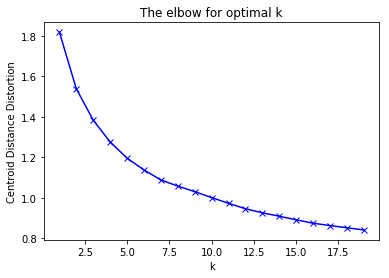

In [3]:
# Standardize the input features
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform( df[kmeans_columns] ), columns=kmeans_columns)
    
# create new plot and data
X = df_standardized  # Should we use standardized inputs data to Kmeans?  Yes.
 
# k means determine k
distortions = []
kmax = 20
K = range(1,kmax)
for k in K:
    t1 = time.time()
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    print("Processed kmeans for k=%d of %d - Time: %0.3fs." % (k, kmax, (time.time() - t1)), end='\r', flush=True)
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Centroid Distance Distortion')
plt.title('The elbow for optimal k')
plt.show()

In [4]:
optimal_k = 7

kmeans = KMeans(n_clusters=optimal_k).fit(X)
cluster_dist = kmeans.transform(X)

# Save the cluster label to the dataframe
df['cluster_number'] = kmeans.labels_

# Save the confidence of the cluster, using closeness of distance to the centroid 
# relative to the other observation distances to the centroid
cl_df = pd.DataFrame(cluster_dist)
d = pd.DataFrame()
for i in range(optimal_k):
    d[i] = pd.qcut(cl_df[i], 10, labels=range(1,11))
df['cluster_confidence'] = [d.loc[i][label] for i, label in enumerate(kmeans.labels_)]

In [5]:
df.head()

,rowID,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,metformin.rosiglitazone,metformin.pioglitazone,change,diabetesMed,readmitted,diag_1_desc,diag_2_desc,diag_3_desc,cluster_number,cluster_confidence
0,1,Caucasian,Female,[50-60),?,Elective,Discharged to home,Physician Referral,1,CP,...,No,No,No,No,False,Spinal stenosis in cervical region,Spinal stenosis in cervical region,"Effusion of joint, site unspecified",4,1
1,2,Caucasian,Female,[20-30),[50-75),Urgent,Discharged to home,Physician Referral,2,UN,...,No,No,No,No,False,"First-degree perineal laceration, unspecified ...","Diabetes mellitus of mother, complicating preg...",Sideroblastic anemia,4,3
2,3,Caucasian,Male,[80-90),?,Not Available,Discharged/transferred to home with home healt...,NaN,7,MC,...,No,No,No,Yes,True,Pneumococcal pneumonia [Streptococcus pneumoni...,"Congestive heart failure, unspecified",Hyperosmolality and/or hypernatremia,6,4
3,4,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Transfer from another health care facility,4,UN,...,No,No,No,Yes,False,Cellulitis and abscess of face,Streptococcus infection in conditions classifi...,Diabetes mellitus without mention of complicat...,2,3
4,5,AfricanAmerican,Female,[50-60),?,Emergency,Discharged to home,Emergency Room,5,?,...,No,No,Ch,Yes,False,"Bipolar I disorder, single manic episode, unsp...",Diabetes mellitus without mention of complicat...,Depressive type psychosis,2,3


          0         1         2         3         4         5         6
0  2.568283  2.810647  2.630604  3.459205  1.065775  3.437186  1.946475
1  2.608973  4.068300  3.336115  4.432654  2.072396  5.134976  3.476789
2  1.792739  2.820515  2.609281  2.493966  3.197100  4.184076  1.770003
3  1.345590  1.927279  0.994831  2.831635  2.277543  4.781869  2.147051
4  1.253597  1.658530  1.155091  2.308300  2.602661  4.354187  1.458311


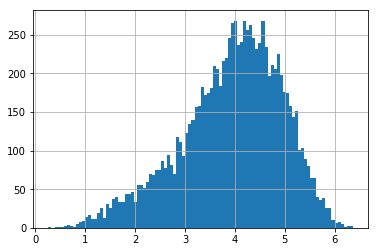

In [6]:
print(cl_df.head())
cl_df[5].hist(bins=100)

kmeans cluster value counts:
 2    2653
1    1790
0    1503
6    1215
4    1187
3    1096
5     556
Name: cluster_number, dtype: int64


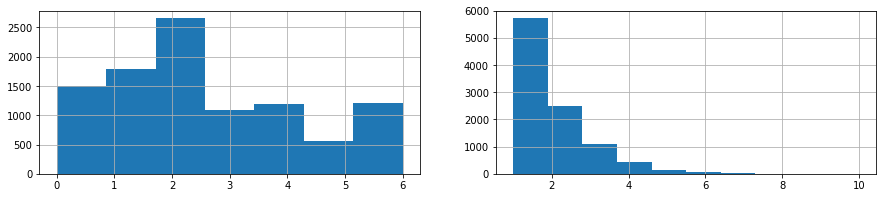

In [7]:
fig, axs = plt.subplots(1,2, figsize=(15,3))
df.cluster_number.hist(bins=optimal_k, ax=axs[0])
df.cluster_confidence.hist(bins=10, ax=axs[1])
print('kmeans cluster value counts:\n',df.cluster_number.value_counts())

In [8]:
# Write the dataframe to csv
file_with_topics = file_path + file_name + '_with_kmeans_clusters' + file_extn
df.to_csv(file_with_topics)

# Create a new DataRobot project with the new dataset with cluster features

In [148]:
dr.Client(token=os.environ['DATAROBOT_API_TOKEN'], endpoint=os.environ['DATAROBOT_ENDPOINT'])

In [149]:
# # Create a project: and upload the data, set the target, give the project a name
project = dr.Project.create(sourcedata=file_with_topics, 
                            project_name="{} with kmeans clustering".format(source_used))

print('project id:  ', project.id)
print('project name:', project.project_name)
print('project.get_status():\n- ', project.get_status())

project id:   5b0498db6cd83a5985c870c5
project name: 10kDiabetes with kmeans clustering
project.get_status():
-  {'autopilot_done': False, 'stage_description': 'Ready to set target', 'stage': 'aim'}


In [150]:
# Output the identified project features# Outpu 
features = project.get_features()
sorted([f.name for f in features])

['A1Cresult',
 'Unnamed: 0',
 'acarbose',
 'acetohexamide',
 'admission_source_id',
 'admission_type_id',
 'age',
 'change',
 'chlorpropamide',
 'citoglipton',
 'cluster_confidence',
 'cluster_number',
 'diabetesMed',
 'diag_1',
 'diag_1_desc',
 'diag_2',
 'diag_2_desc',
 'diag_3',
 'diag_3_desc',
 'discharge_disposition_id',
 'examide',
 'gender',
 'glimepiride',
 'glimepiride_pioglitazone',
 'glipizide',
 'glipizide_metformin',
 'glyburide',
 'glyburide_metformin',
 'insulin',
 'max_glu_serum',
 'medical_specialty',
 'metformin',
 'metformin_pioglitazone',
 'metformin_rosiglitazone',
 'miglitol',
 'nateglinide',
 'num_lab_procedures',
 'num_medications',
 'num_procedures',
 'number_diagnoses',
 'number_emergency',
 'number_inpatient',
 'number_outpatient',
 'payer_code',
 'pioglitazone',
 'race',
 'readmitted',
 'repaglinide',
 'rosiglitazone',
 'rowID',
 'time_in_hospital',
 'tolazamide',
 'tolbutamide',
 'troglitazone',
 'weight']

In [151]:
# Convert top topic to a categorical variable
new_feature = project.create_type_transform_feature(name='cluster_number_cat', 
                                      parent_name='cluster_number', 
                                      variable_type='categoricalInt')
new_feature

Feature(cluster_number_cat)

In [152]:
# By calling set_target, we run datarobot
target=target
project.set_target(target=target, 
                   mode='auto',
                   worker_count=20)

Project(10kDiabetes with kmeans clustering)

In [153]:
# Get the models, which are already ordered by rank from the leaderboard
models = project.get_models()

# Get the best performing model (excluding the blenders, which are typically the top 4 models)
best_model = models[4]
print('Best model from the leaderboard:\n\'%s\'' % best_model.model_type)
print()

# Get the blueprint
blueprint_id = best_model.blueprint_id
blueprint = dr.models.Blueprint.get(project.id, blueprint_id)
print('Best model blueprint preprocessing steps:')
pprint(blueprint.processes)
print()

# Get the model scoring metrics
print('Best model metrics:')
pprint(best_model.metrics)

Best model from the leaderboard:
'Regularized Logistic Regression (L2)'

Best model blueprint preprocessing steps:
['One-Hot Encoding',
 'Matrix of word-grams occurrences',
 'Missing Values Imputed',
 'Smooth Ridit Transform',
 'Standardize',
 'Regularized Logistic Regression (L2)']

Best model metrics:
{'AUC': {'backtesting': None,
         'backtestingScores': None,
         'crossValidation': None,
         'holdout': None,
         'validation': 0.69358},
 'FVE Binomial': {'backtesting': None,
                  'backtestingScores': None,
                  'crossValidation': None,
                  'holdout': None,
                  'validation': 0.08293},
 'Gini Norm': {'backtesting': None,
               'backtestingScores': None,
               'crossValidation': None,
               'holdout': None,
               'validation': 0.38716},
 'Kolmogorov-Smirnov': {'backtesting': None,
                        'backtestingScores': None,
                        'crossValidation': None